# Traffic Tune - Optimizing Traffic Signals with Reinforcement Learning

## Introduction

Welcome to the Traffic Tune POC notebook. Our project focused on optimizing traffic signal control using reinforcement learning. Traffic congestion is a major problem in urban areas, leading to increased travel times, fuel consumption, and pollution. Traditional traffic signal control systems often struggle to adapt to dynamic traffic conditions, resulting in suboptimal traffic flow.

Traffic Tune is a recommendation system that leverages reinforcement learning to dynamically adjust traffic signals at intersections. By learning from traffic patterns in real-time, Traffic Tune aims to improve traffic flow, reduce congestion, and enhance overall transportation efficiency.

In this POC, we will demonstrate how to train a reinforcement learning agent to optimize traffic signal control in a simulated environment. We will use the SUMO (Simulation of Urban MObility) traffic simulation tool and the Stable Baselines3 library to train a Deep Q-Network (DQN) agent to learn an optimal traffic signal control policy.


# Setup and Installations

In [107]:
import stable_baselines3
import matplotlib
import traci
import sumo_rl
import imageio
import numpy as np
import tensorboard
import os
import sys
import gymnasium as gym
from stable_baselines3.dqn.dqn import DQN

from sumo_rl import SumoEnvironment
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
import imageio.v2 as imageio
from IPython.display import Video
import pandas as pd
import xml.etree.ElementTree as ET

In [108]:
print("SUMO_HOME:", os.environ.get("SUMO_HOME"))
# Get the path to the installed sumo-rl package
sumo_rl_path = os.path.dirname(sumo_rl.__file__)
print("Path to sumo-rl package:", sumo_rl_path)

SUMO_HOME: /opt/homebrew/opt/sumo/share/sumo
Path to sumo-rl package: /Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl


# Environment Setup

In [109]:
if "SUMO_HOME" in os.environ:
    tools = os.path.join(os.environ["SUMO_HOME"], "tools")
    sys.path.append(tools)
else:
    sys.exit("Please declare the environment variable 'SUMO_HOME'")

### Setup Timestamp for Training

In [110]:
jerusalem_tz = pytz.timezone('Asia/Jerusalem')

jerusalem_time = datetime.now(jerusalem_tz)

# Format the timestamp
timestamp = jerusalem_time.strftime("%Y%m%d_%H%M%S")

### SUMO Package Path and Configuration File


In [111]:
package_path = os.path.dirname(sumo_rl.__file__)
sumo_cfg_path = os.path.join(package_path, "nets/single-intersection/single-intersection.sumocfg")


### Environment preparations

In [112]:
def initialize_sumo_environment(num_seconds, min_green, max_green,title ):
    env = SumoEnvironment(
        net_file=f"{package_path}/nets/single-intersection/single-intersection.net.xml",
        route_file=f"{package_path}/nets/single-intersection/single-intersection.rou.xml",
        out_csv_name=f"Outputs/single-intersection/{title}/dqn_{timestamp}.csv",
        single_agent=True,
        use_gui=True,
        num_seconds=num_seconds,
        min_green=min_green,
        max_green=max_green,
    )
    return env

num_seconds_1 = 3600
min_green_1 = 42
max_green_1 = 42

num_seconds_2 = 3600
min_green_2 = 5
max_green_2 = 50

env_dqn_agent = initialize_sumo_environment(num_seconds_1, min_green_1, max_green_1, 'DQN_Agent')
print("Environment initialized for DQN Agent")
env_fixed_policy = initialize_sumo_environment(num_seconds_2, min_green_2, max_green_2, 'Naive_Policy')
print("Environment initialized for Naive Policy")

 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
Environment initialized for DQN Agent
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 3ms, vehicles TOT 0 ACT 0 BUF 0)                      
Environment initialized for Naive Policy


# Initialize models

In [113]:
def initialize_models(env_dqn_agent, env_fixed_policy):
    rl_model_params = {
        "env": env_dqn_agent,
        "policy": "MlpPolicy",
        "learning_rate": 0.001,
        "learning_starts": 0,
        "train_freq": 1,
        "target_update_interval": 1,
        "exploration_initial_eps": 0.05,
        "exploration_final_eps": 0.01,
        "verbose": 2,
    }

    naive_model_params = {
        "env": env_fixed_policy,
        "policy": "MlpPolicy",
        "learning_rate": 0.00000000000001,
        "learning_starts": 0,
        "train_freq": 1,
        "target_update_interval": 1,
        "exploration_initial_eps": 0.05,
        "exploration_final_eps": 0.01,
        "verbose": 2,
    }

    rl_model = DQN(**rl_model_params)
    naive_model = DQN(**naive_model_params)

    return rl_model, naive_model

rl_model, naive_model = initialize_models(env_dqn_agent, env_fixed_policy)
print("Models initialized")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Models initialized


# Training the agent

### Run the following code to get the path to the SUMO remote server


In [18]:
# Use the package path in your command
if package_path:
    cmd = f"sumo-gui -c {sumo_cfg_path} --remote-port 65533"
    print("Run the following command in the terminal to start the SUMO server:")
    print(cmd)
else:
    print("sumo-rl package not found. Make sure it is installed.")

Run the following command in the terminal to start the SUMO server:
sumo-gui -c /Users/md/anaconda3/lib/python3.11/site-packages/sumo_rl/nets/single-intersection/single-intersection.sumocfg --remote-port 65533


In [114]:
if __name__ == "__main__":
    print("Connecting to SUMO server...")
    traci.connect(port=65533)
    print("Connected to SUMO server")
    
    
    num_of_episodes = 1
    print("Starting training")
    rl_model.learn(total_timesteps=(720*num_of_episodes))
    print("Training completed")

    # Save the model
    rl_model.save(f'savedAgent/single-intersection/dqnEpNum{num_of_episodes}')
    print("Model saved")

    # Close the TraCI connection
    traci.close()
    print("TraCI connection closed")


Connecting to SUMO server...
Connected to SUMO server
Starting training
 Retrying in 1 seconds
 Retrying in 1 seconds
Training completed
Model saved
TraCI connection closed


# Agent Prediction

Connecting to SUMO server...
Connected to SUMO server
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Truncated: True
 Retrying in 1 seconds
Truncated: True
 Retrying in 1 seconds
Truncated: True
Overall Average Waiting Time: 6.90 seconds


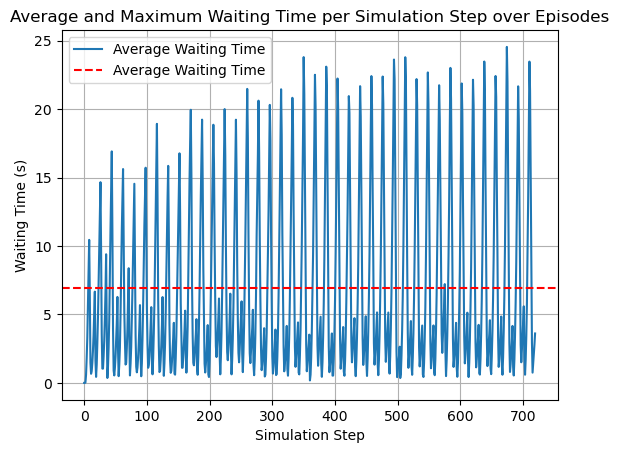

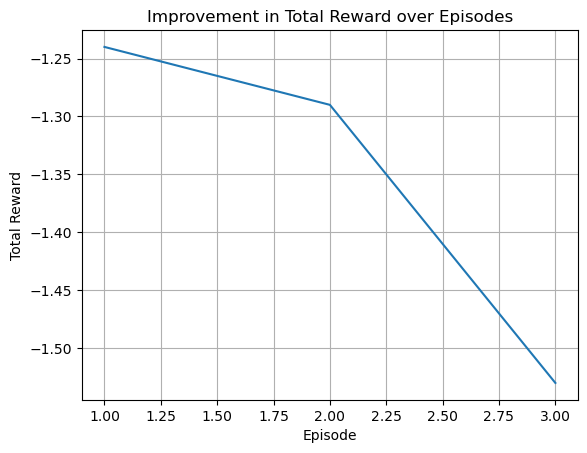

In [120]:
def capture_screenshot(output_path, episode, step):
    file_name = f"episode_{episode}_step_{step}.png"
    file_path = os.path.join(output_path, file_name)
    traci.gui.screenshot(traci.gui.DEFAULT_VIEW, file_path)

def agent_predict(env, model, episodes, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    rewards_per_episode = []  # List to store rewards for each episode
    all_average_waiting_times = []  # List to store average waiting times for each episode

    for episode in range(episodes):
        obs, info = env.reset()
        step = 0
        total_reward = 0  # Variable to store total reward for the episode
        truncated = False
        step_waiting_times = []  # List to store waiting times for this episode

        while not truncated:
            action, _states = model.predict(obs)
            results = env.step(action)
            if len(results) == 5:
                obs, rewards, _, truncated, info = results
                if truncated:
                    print(f"Truncated: {truncated}")
            else:
                raise ValueError(f"Expected 5 values from env.step(), got {len(results)}")
            total_reward += rewards  # Accumulate rewards

            # Collect waiting times at each step
            total_waiting_time = 0
            vehicle_count = 0
            for veh_id in traci.vehicle.getIDList():
                total_waiting_time += traci.vehicle.getWaitingTime(veh_id)
                vehicle_count += 1

            # Calculate the average waiting time for this step
            if vehicle_count > 0:
                average_waiting_time = total_waiting_time / vehicle_count
            else:
                average_waiting_time = 0

            step_waiting_times.append(average_waiting_time)

            # Capture and save the environment state every 10 steps
            # if step % 10 == 0:
            #     capture_screenshot(save_path, episode, step)
            
            step += 1

        rewards_per_episode.append(total_reward)  # Append total reward for this episode
        all_average_waiting_times.append(step_waiting_times)  # Append waiting times for this episode

    return rewards_per_episode, all_average_waiting_times

def plot_average_waiting_times(all_average_waiting_times, duration):
    avg_waiting_times_per_step = [sum(times) / len(times) for times in zip(*all_average_waiting_times)]
    overall_avg_waiting_time = sum(avg_waiting_times_per_step) / len(avg_waiting_times_per_step)
    print(f"Overall Average Waiting Time: {overall_avg_waiting_time:.2f} seconds")
    
    plt.plot(avg_waiting_times_per_step, label='Average Waiting Time')
    plt.axhline(y=overall_avg_waiting_time, color='r', linestyle='--', label='Average Waiting Time')

    plt.title('Average and Maximum Waiting Time per Simulation Step over Episodes')
    plt.xlabel('Simulation Step')
    plt.ylabel('Waiting Time (s)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

def plot_total_rewards(rewards_per_episode):
    plt.plot(range(1, len(rewards_per_episode) + 1), rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Improvement in Total Reward over Episodes')
    plt.grid(True)
    plt.show()


print("Connecting to SUMO server...")
traci_connection_predict = traci.connect(port=65533)
print("Connected to SUMO server")

# Parameters
episodes = 3
duration = 3600  # in seconds
port = 65533
save_path = 'Outputs/single-intersection/dqn_images'

env_dqn_agent = initialize_sumo_environment(num_seconds_1, min_green_1, max_green_1, 'DQN_Agent')
loaded_model = DQN.load('/Users/md/Desktop/Traffic_Tune_POC/Traffic_Tune_POC/savedAgent/single-intersection/dqnEpNum1.zip')

# Run the simulation over multiple episodes and collect average waiting times per step
rewards_per_episode, all_average_waiting_times = agent_predict(env_dqn_agent, loaded_model, episodes, save_path)
traci.close()
# Plot the average waiting times per simulation step
plot_average_waiting_times(all_average_waiting_times, duration)

# Plot the total rewards per episode
plot_total_rewards(rewards_per_episode)


# Create a Video from the Captured Images

In [ ]:
def create_video(output_path, title):
    images = []
    for file_name in sorted(os.listdir(output_path)):
        if file_name.endswith(".png"):
            file_path = os.path.join(output_path, file_name)
            images.append(imageio.imread(file_path))
    video_path = f'{title}.mp4'
    imageio.mimsave(video_path, images, fps=10)
    return Video(video_path)


create_video("outputs/single-intersection/dqn_images", "DQN Agent Solution")


# Visualizing and Analyzing the Results

## Waiting time per episode

In [ ]:

def plot_metrics(data, title, ax):
    ax.plot(data['step'], data['system_mean_waiting_time'], label='System Mean Waiting Time')
    ax.set_xlabel('Step Time')
    ax.set_ylabel('System Mean Waiting Time')
    ax.set_title(title)
    ax.legend()

def visualize_results():
    episodes = range(1, 10, 1)
    fig, axs = plt.subplots(len(episodes)//2, 2, figsize=(15, 20))
    axs = axs.flatten()

    for i, episode in enumerate(episodes):
        file_path = f"Outputs/single-intersection/DQN_Agent/dqn_20240613_114828.csv_conn42_ep{episode}.csv"
        title = f"DQN Agent Solution - Episode {episode}"
        
        try:
            data = pd.read_csv(file_path)
            if 'step' not in data.columns or 'system_mean_waiting_time' not in data.columns:
                raise KeyError("CSV file does not contain required columns: 'step' and 'system_mean_waiting_time'")
            
            plot_metrics(data, title, axs[i])
        
        except FileNotFoundError:
            print(f"File not found: {file_path}")
        except KeyError as e:
            print(e)

    plt.tight_layout()
    plt.show()

visualize_results()
    

## Average Waiting Time in Naive Solution

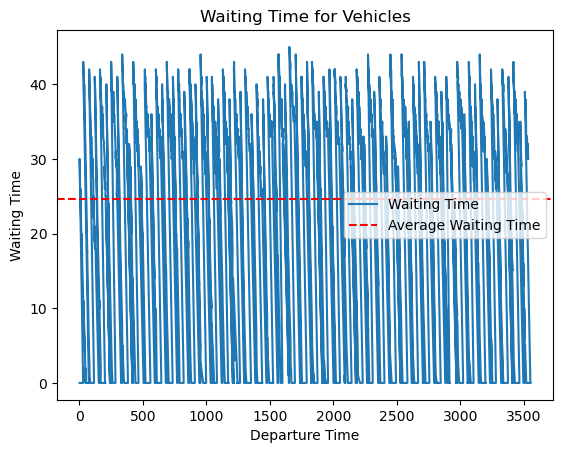

Average Waiting Time: 24.59 seconds


In [118]:
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

def plot_waiting_time(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    depart_times = []
    waiting_times = []

    for tripinfo in root.findall('tripinfo'):
        depart_time = float(tripinfo.get('depart'))
        waiting_time = float(tripinfo.get('waitingTime'))

        depart_times.append(depart_time)
        waiting_times.append(waiting_time)

    average_waiting_time = sum(waiting_times) / len(waiting_times)

    plt.plot(depart_times, waiting_times, label='Waiting Time')
    plt.axhline(y=average_waiting_time, color='r', linestyle='--', label='Average Waiting Time')
    plt.xlabel('Departure Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Time for Vehicles')
    plt.legend()
    plt.show()

    print(f"Average Waiting Time: {average_waiting_time:.2f} seconds")

# Example usage
xml_file_path = '/Users/md/Desktop/sumo-rl/nets/single-intersection/trip_info.xml'
plot_waiting_time(xml_file_path)


## Calculate the Overall Average Waiting Time

### DQN Agent Solution and Naive Solution

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_average_waiting_time(file_path, episodes, title):
    mean_average_waiting_time = 0
    list_of_average = []

    for episode in episodes:
        episode_file_path = f'{file_path}_ep{episode}.csv'
        data = pd.read_csv(episode_file_path)
        average_waiting_time = data['system_mean_waiting_time'].mean()
        mean_average_waiting_time += average_waiting_time
        list_of_average.append(average_waiting_time)

    overall_mean_average_waiting_time = mean_average_waiting_time / len(episodes)
    print(f'The overall average waiting time is: {overall_mean_average_waiting_time}\n')

    plt.figure(figsize=(12, 8))
    plt.plot(episodes, list_of_average, marker='o', linestyle='-', color='r', label='Avg Waiting Time')
    plt.xlabel('Episode')
    plt.ylabel('Average Waiting Time')
    plt.title(f'Improvement in System Mean Waiting Time over Episodes - {title}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

agent_file_path = 'Outputs/single-intersection/dqn_20240612_164825.csv_conn1'
episods_learning_phase = range(5, 85, 5) # Change the range as needed
episods_prediction_phase = range(1, 5) # Change the range as needed

plot_average_waiting_time(agent_file_path, episods_learning_phase, 'DQN Agent Learning')
plot_average_waiting_time(agent_file_path, episods_prediction_phase, 'DQN Agent Prediction')
